In [1]:
import sys
sys.path.append("/home/jzh/data_jzh/pints_related/gits_2/pySDC")
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import statistics
import pySDC.helpers.plot_helper as plt_helper
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI
from pySDC.projects.DAE.problems.ThreeInverterSystem import ThreeInverterSystem
from pySDC.projects.DAE.problems.WSCC9BusSystem_noSE import WSCC9BusSystem

from pySDC.projects.DAE.sweepers.fully_implicit_DAE import fully_implicit_DAE
from pySDC.projects.DAE.sweepers.Runge_Kutta_DAE import BackwardEulerDAE, ImplicitMidpointMethodIMEXDAE, DIRK43_2DAE, TrapezoidalRuleDAE, EDIRK4_DAE

# from pySDC.projects.DAE.misc.HookClass_DAE import approx_solution_hook
# from pySDC.projects.DAE.misc.HookClass_DAE import error_hook
from pySDC.implementations.hooks.log_solution import LogSolution

from pySDC.helpers.stats_helper import get_sorted
from pySDC.helpers.stats_helper import filter_stats



In [2]:
class TimeSeries:
    """Stores data from different simulation sources.
        A TimeSeries object always consists of timestamps and datapoints.
    """
    def __init__(self, name, time, values, label=""):
        self.time = np.array(time)
        self.values = np.array(values)
        self.name = name
        if not label:
            self.label = name
        else:
            self.label = label
    
    def __mul__(self, ts):
        if isinstance(ts, TimeSeries):
            new_val = self.values * ts.values
        else:
            new_val = self.values * ts
        return TimeSeries(self.name+"_mul", self.time, new_val)
    
    def abs(self):
        """ Calculate absolute value of complex time series.
        """
        abs_values = []
        for value in self.values:
            abs_values.append(np.abs(value))
        ts_abs = TimeSeries(self.name+'_abs', self.time, abs_values, self.label+'_abs')
        return ts_abs

    def phase(self):
        """ Calculate phase of complex time series.
        """
        phase_values = []
        for value in self.values:
            phase_values.append(np.angle(value, deg=True))
        ts_phase = TimeSeries(self.name+'_phase', self.time, phase_values, self.label+'_phase')
        return ts_phase

    @staticmethod
    def rel_diff(name, ts1, ts2, normalize = None, point_wise = False, threshold = 0):
        """
        Returns relative difference between two time series objects to the first.
        calculated against the max of ts1.
        """
        diff_ts = TimeSeries.diff('diff', ts1, ts2)
        diff_val=diff_ts.values
        if normalize is not None:
            rel_diff_to_ts1 = diff_val/normalize
            ts_rel_diff_to_ts1 = TimeSeries(name, diff_ts.time, rel_diff_to_ts1)
            return ts_rel_diff_to_ts1
        # relative error to the max value of ts1
        if not point_wise:
            rel_diff_to_ts1 = diff_val/np.abs(ts1.values).max()
            ts_rel_diff_to_ts1 = TimeSeries(name, diff_ts.time, rel_diff_to_ts1)
        else:
            # calculate the relative point-wise error above threshold 
            index_=np.where(np.abs(ts1.values)>threshold)
            ts1_filtered_val_=ts1.values[index_]
            ts1_filtered_time_=ts1.time[index_]
            #ts2_filtered_val_=ts2.values[index_]
            diff_val_filtered=diff_val[index_]
            rel_diff_to_ts1 = diff_val_filtered/ts1_filtered_val_
            ts_rel_diff_to_ts1 = TimeSeries(name, ts1_filtered_time_, np.abs(rel_diff_to_ts1))
        return ts_rel_diff_to_ts1
    
    @staticmethod
    def diff(name, ts1, ts2):
        """Returns difference between values of two Timeseries objects.
        """
        if len(ts1.time) == len(ts2.time):
            ts_diff = TimeSeries(name, ts1.time, (ts1.values - ts2.values))
        else:  # different timestamps, common time vector and interpolation required before substraction
            time = sorted(set(list(ts1.time) + list(ts2.time)))
            interp_vals_ts1 = np.interp(time, ts1.time, ts1.values)
            interp_vals_ts2 = np.interp(time, ts2.time, ts2.values)
            ts_diff = TimeSeries(name, time, (interp_vals_ts2 - interp_vals_ts1))
        return ts_diff

    @staticmethod
    def abs_rel_diff(name, ts1, ts2, normalize = None, point_wise = False, threshold = 0):
        ts_rel_diff = TimeSeries.rel_diff(name, ts1, ts2, normalize, point_wise, threshold)
        ts_rel_diff.values = np.abs(ts_rel_diff.values)
        return ts_rel_diff


## Generate simulation data

In [3]:

def single_run(run_name="test", time_step=1e-1, end_time=0.1, sweeper_type = BackwardEulerDAE, newton_tol=1e-3):
    """
    A testing ground for the synchronous machine model
    """
    # initialize level parameters
    level_params = dict()
    level_params['restol'] = 1e-7
    level_params['dt'] = time_step

    # initialize sweeper parameters
    M_fix = 3
    sweeper_params = {
        'num_nodes': M_fix,
        'quad_type': 'RADAU-RIGHT',
        'QI': 'IE',
    }

    # initialize problem parameters
    problem_params = dict()
    problem_params['newton_tol'] = newton_tol  # tollerance for implicit solver
    problem_params['nvars'] = 36

    # initialize step parameters
    step_params = dict()
    step_params['maxiter'] = 100

    # initialize controller parameters
    controller_params = dict()
    controller_params['logger_level'] = 30
    controller_params['hook_class'] = [LogSolution]

    # Fill description dictionary for easy hierarchy creation
    description = dict()
    description['problem_class'] = ThreeInverterSystem
    description['problem_params'] = problem_params
    description['sweeper_class'] = sweeper_type
    description['sweeper_params'] = sweeper_params
    description['level_params'] = level_params
    description['step_params'] = step_params

    Path("data").mkdir(parents=True, exist_ok=True)

    # instantiate the controller
    controller = controller_nonMPI(num_procs=1, controller_params=controller_params, description=description)

    # set time parameters
    t0 = 0.0
    Tend = end_time

    # get initial values on finest level
    P = controller.MS[0].levels[0].prob
    uinit = P.u_exact(t0)

    # call main function to get things done...
    uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)


    # store results
    sol = get_sorted(stats, type='approx_solution', sortby='time')
    sol_dt = np.array([sol[i][0] for i in range(len(sol))])
    sol_data = np.array([[sol[j][1][i] for j in range(len(sol))] for i in range(problem_params['nvars'])])
    niter = filter_stats(stats, type='niter')
    niter = np.fromiter(niter.values(), int)

    t = np.array([me[0] for me in get_sorted(stats, type='u', sortby='time')])
    # print([me[1][11*m + 2*m:11*m + 2*m + n] for me in get_sorted(stats, type='approx_solution', sortby='time', recomputed=False)])
    i_c1 = np.array([ me[1][0:2] for me in get_sorted(stats, type='u', sortby='time')])
    i_c2 = np.array([ me[1][8:10] for me in get_sorted(stats, type='u', sortby='time')])
    i_c3 = np.array([ me[1][16:18] for me in get_sorted(stats, type='u', sortby='time')])

    v_cc1 = np.array([ me[1][6:8] for me in get_sorted(stats, type='u', sortby='time')])
    v_cc2 = np.array([ me[1][14:16] for me in get_sorted(stats, type='u', sortby='time')])
    v_cc3 = np.array([ me[1][22:24] for me in get_sorted(stats, type='u', sortby='time')])

    delta1 = np.array([ me[1][5] for me in get_sorted(stats, type='u', sortby='time')])
    delta2 = np.array([ me[1][13] for me in get_sorted(stats, type='u', sortby='time')])
    delta3 = np.array([ me[1][21] for me in get_sorted(stats, type='u', sortby='time')])

    i_pccDQ = np.array([ me[1][24:26] for me in get_sorted(stats, type='u', sortby='time')])
    il_12DQ = np.array([ me[1][26:28] for me in get_sorted(stats, type='u', sortby='time')])
    il_23DQ = np.array([ me[1][28:30] for me in get_sorted(stats, type='u', sortby='time')])

    i_g1DQ = i_pccDQ - il_12DQ
    i_g2DQ = il_12DQ - il_23DQ
    i_g3DQ = il_23DQ

    i_g1=np.zeros_like(i_g1DQ)
    i_g2=np.zeros_like(i_g2DQ)
    i_g3=np.zeros_like(i_g3DQ)

    for k in range(len(delta1)):
        rotation_matrix1 = np.array([[np.cos(delta1[k]), np.sin(delta1[k])], [-np.sin(delta1[k]), np.cos(delta1[k])]])
        i_g1[k, :] = np.dot(rotation_matrix1, i_g1DQ[k, :])

        rotation_matrix2 = np.array([[np.cos(delta2[k]), np.sin(delta2[k])], [-np.sin(delta2[k]), np.cos(delta2[k])]])
        i_g2[k, :] = np.dot(rotation_matrix2, i_g2DQ[k, :])

        rotation_matrix3 = np.array([[np.cos(delta3[k]), np.sin(delta3[k])], [-np.sin(delta3[k]), np.cos(delta3[k])]])
        i_g3[k, :] = np.dot(rotation_matrix3, i_g3DQ[k, :])

    fs = 2000
    Ts = 1/fs
    Lf = 0.1e-3;    # L Filter
    Kp  = Lf*1.8/(3*Ts)


    v_g1 = Kp*(i_c1-i_g1) + v_cc1
    v_g2 = Kp*(i_c2-i_g2) + v_cc2 
    v_g3 = Kp*(i_c3-i_g3) + v_cc3 

    # Initialize i_pcc as a zeros matrix with the same shape as i_pccDQ
    i_pcc = np.zeros_like(i_pccDQ)

    # Perform the matrix operations
    for k in range(len(delta1)):
        rotation_matrix = np.array([[np.cos(delta1[k]), np.sin(delta1[k])],
                                    [-np.sin(delta1[k]), np.cos(delta1[k])]])
        i_pcc[k, :] = np.dot(rotation_matrix, i_pccDQ[k, :])

    # Set v_pcc to v_g1
    v_pcc = v_g1

    # Transpose i_pcc
    i_pcc = i_pcc.T

    # file_name_suffix = "invSys"
    # fig, ax = plt_helper.plt.subplots(1, 1, figsize=(4.5, 3))
    # ax.plot(t, v_pcc[:, 0], label='v_pcc_d')
    # ax.plot(t, v_pcc[:, 1], label='v_pcc_q')
    # ax.legend(loc='upper right', fontsize=10)
    # ax.set_xlim(0.9,1.7)
    # # plt_helper.plt.show()
    # fig.savefig(f'data/{run_name}_{file_name_suffix}_v_pcc.png', dpi=300, bbox_inches='tight')
    return TimeSeries(run_name, t, v_pcc) # return d-, q-axis 


In [18]:

def single_run_wscc(run_name="test", time_step=1e-1, end_time=0.1, sweeper_type = BackwardEulerDAE, newton_tol = 1e-6):
    """
    A testing ground for the synchronous machine model
    """
    # initialize level parameters
    level_params = dict()
    level_params['restol'] = 1e-7
    level_params['dt'] = time_step

    # initialize sweeper parameters
    M_fix = 3
    sweeper_params = {
        'num_nodes': M_fix,
        'quad_type': 'RADAU-RIGHT',
        'QI': 'IE',
    }

    # initialize problem parameters
    problem_params = dict()
    problem_params['newton_tol'] = newton_tol  # tollerance for implicit solver
    problem_params['nvars'] = 36

    # initialize step parameters
    step_params = dict()
    step_params['maxiter'] = 100

    # initialize controller parameters
    controller_params = dict()
    controller_params['logger_level'] = 30
    controller_params['hook_class'] = [LogSolution]

    # Fill description dictionary for easy hierarchy creation
    description = dict()
    # description['problem_class'] = ThreeInverterSystem
    description['problem_class'] = WSCC9BusSystem
    description['problem_params'] = problem_params
    description['sweeper_class'] = sweeper_type
    description['sweeper_params'] = sweeper_params
    description['level_params'] = level_params
    description['step_params'] = step_params

    Path("data").mkdir(parents=True, exist_ok=True)

    # instantiate the controller
    controller = controller_nonMPI(num_procs=1, controller_params=controller_params, description=description)

    # set time parameters
    t0 = 0.0
    Tend = end_time

    # get initial values on finest level
    P = controller.MS[0].levels[0].prob
    uinit = P.u_exact(t0)

    # call main function to get things done...
    uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)


    # store results
    sol = get_sorted(stats, type='approx_solution', sortby='time')
    sol_dt = np.array([sol[i][0] for i in range(len(sol))])
    sol_data = np.array([[sol[j][1][i] for j in range(len(sol))] for i in range(problem_params['nvars'])])
    niter = filter_stats(stats, type='niter')
    niter = np.fromiter(niter.values(), int)

    t = np.array([me[0] for me in get_sorted(stats, type='u', sortby='time')])
    # print([me[1][11*m + 2*m:11*m + 2*m + n] for me in get_sorted(stats, type='approx_solution', sortby='time', recomputed=False)])
    m=3
    n=9
    V = np.array([me[1][11 * m + 2 * m : 11 * m + 2 * m + n] for me in get_sorted(stats, type='u', sortby='time')])[
        :, 0
    ] # get V0
    return TimeSeries(run_name, t, V) # return V0


In [26]:
# reference = RungeKuttaDAE
# reference = fully_implicit_DAE

reference = BackwardEulerDAE
# reference_res = single_run("reference", 100e-6, 5e-3, reference)
reference_res_wscc = single_run_wscc("reference", 1e-6, 5e-6, DIRK43_2DAE, 1e-3)



sweeper - WARNING: "num_nodes" will be ignored by Runge-Kutta sweeper
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.5         0.          0.          0.          0.        ]
 [ 0.          0.16666667  0.5         0.          0.          0.        ]
 [ 0.         -0.5         0.5         0.5         0.          0.        ]
 [ 0.          1.5        -1.5         0.5         0.5         0.        ]
 [ 0.          1.5        -1.5         0.5         0.5         0.        ]]
[0.5        0.66666667 0.5        1.         1.        ]
sweeper - WARNING: Overwriting residual tolerance with -1 because RK methods are direct and hence may not compute a residual at all!


In [13]:
# store ref

# pickle.dump(reference_res, open("data/pintsime2/reference_eb_50us_ts.p", 'wb'))
# pickle.dump(reference_res, open("data/pintsime2/reference_eb_100us_ts.p", 'wb'))


In [4]:
# method_list = [DIRK43_2DAE, ImplicitMidpointMethodIMEXDAE, fully_implicit_DAE]
# method_list_2 = [TrapezoidalRuleDAE, EDIRK4_DAE]
method_list = [DIRK43_2DAE, ImplicitMidpointMethodIMEXDAE, fully_implicit_DAE, TrapezoidalRuleDAE, EDIRK4_DAE]


dt_list = [200e-6, 250e-6, 500e-6, 1000e-6]



res_candidates= {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[]
}


# run and store
# for i_meth in range(len(method_list)):
for i_meth in [3,4]:
    for dt_ in dt_list: 
        res_ = single_run(f"{i_meth}_{dt_}", dt_, 5e-3, method_list[i_meth])
        res_candidates[i_meth].append(res_)

# pickle.dump(res_candidates[0], open("data/pintsime2/DIRK43_2DAE_ts.p", 'wb'))
# pickle.dump(res_candidates[1], open("data/pintsime2/ImplicitMidpointMethodIMEXDAE_ts.p", 'wb'))
# pickle.dump(res_candidates[2], open("data/pintsime2/fully_implicit_DAE_ts.p", 'wb'))
pickle.dump(res_candidates[3], open("data/pintsime2/TrapezoidalRuleDAE_ts.p", 'wb'))
pickle.dump(res_candidates[4], open("data/pintsime2/EDIRK4_DAE_ts.p", 'wb'))



sweeper - WARNING: "num_nodes" will be ignored by Runge-Kutta sweeper
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]]
[0. 1. 1.]
sweeper - WARNING: Overwriting residual tolerance with -1 because RK methods are direct and hence may not compute a residual at all!


/home/jzh/data_jzh/pints_related/gits_2/pySDC/pySDC/projects/DAE/problems/ThreeInverterSystem.py:231: RuntimeWarning: overflow encountered in scalar multiply
  eqs.append(-3/2 * (1/self.C_dc) * np.dot(np.dot(v_g2.T, Tdelta2), i_g2DQ) / v_dc2 + 1/self.C_dc * self.Power2 / v_dc2 - dv_dc2)


sweeper - WARNING: "num_nodes" will be ignored by Runge-Kutta sweeper
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]]
[0. 1. 1.]
sweeper - WARNING: Overwriting residual tolerance with -1 because RK methods are direct and hence may not compute a residual at all!
sweeper - WARNING: "num_nodes" will be ignored by Runge-Kutta sweeper
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]]
[0. 1. 1.]
sweeper - WARNING: Overwriting residual tolerance with -1 because RK methods are direct and hence may not compute a residual at all!
sweeper - WARNING: "num_nodes" will be ignored by Runge-Kutta sweeper
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]]
[0. 1. 1.]
sweeper - WARNING: Overwriting residual tolerance with -1 because RK methods are direct and hence may not compute a residual at all!
sweeper - WARNING: "num_nodes" will be ignored by Runge-Kutta sweeper
[[ 0.          0.          0.          0.          0.    

## Load Simulation Results

In [34]:
# test = pickle.load("data/DIRK43_2DAE.p", 'rb')

reference_res = pickle.load(open("data/pintsime2/wscc09_reference_eb_50us_ts.p", 'rb'))


# reference_res = pickle.load(open("data/pintsime2/reference_eb_1us_ts.p", 'rb'))
# reference_res = pickle.load(open("data/pintsime2/reference_eb_5us_ts.p", 'rb'))
# reference_res = pickle.load(open("data/pintsime2/reference_eb_50us_ts.p", 'rb'))
# reference_res = pickle.load(open("data/pintsime2/reference_eb_100us_ts.p", 'rb'))
# reference_res = pickle.load(open("data/reference_eb_100us.p", 'rb'))


In [35]:
reference_res.values

array([ 5.52918053e+13,  2.53033757e+13,  8.00467190e+13,  3.86749339e+12,
        3.15589292e+13, -8.43159515e+12,  2.25635191e+13,  1.45128201e+14,
        9.75528228e+13])

In [8]:
# ̄vg = vgd + jvgq 
# mapping the d,q quantities to complex numbers\
reference_res.values = np.vectorize(complex)(reference_res.values[:,0], reference_res.values[:,1])

In [9]:
res_candidates_dq = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[]
}

# dq values are still 2d array, not mapped to complex until calculating the error later!
res_candidates_dq[0] = pickle.load(open("data/pintsime2/DIRK43_2DAE_ts.p", 'rb'))
res_candidates_dq[1] = pickle.load(open("data/pintsime2/ImplicitMidpointMethodIMEXDAE_ts.p", 'rb'))
res_candidates_dq[2] = pickle.load(open("data/pintsime2/fully_implicit_DAE_ts.p", 'rb'))
res_candidates_dq[3] = pickle.load(open("data/pintsime2/TrapezoidalRuleDAE_ts.p", 'rb'))
res_candidates_dq[4] = pickle.load(open("data/pintsime2/EDIRK4_DAE_ts.p", 'rb'))


In [13]:
res_candidates_dq[4]

In [10]:
ar_error_candidates= {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[]
}

dt_list = [200e-6, 250e-6, 500e-6, 1000e-6]
# error based on last step
for key,val in res_candidates_dq.items():
    for res_dt_idx in range(len(val)): 
        if(len(val[res_dt_idx].values) == 0):
            continue
        # first map dq values to complex
        val[res_dt_idx].values = np.vectorize(complex)(val[res_dt_idx].values[:,0], val[res_dt_idx].values[:,1])
        complex_error_ts = TimeSeries.abs_rel_diff(f"d_{key}_{dt_list[res_dt_idx]}", reference_res, val[res_dt_idx])
        ar_error_candidates[key].append(complex_error_ts)


In [14]:
ar_error_candidates

{0: [<__main__.TimeSeries at 0x7f70d30df0a0>,
 1: [<__main__.TimeSeries at 0x7f70d2d967c0>,
 2: [<__main__.TimeSeries at 0x7f70d3207e20>,
 3: [<__main__.TimeSeries at 0x7f70d2d9d2e0>,
 4: [<__main__.TimeSeries at 0x7f70d30eba90>,
  <__main__.TimeSeries at 0x7f70d32f3940>]}

In [18]:
ar_error_candidates[3]

# Plots

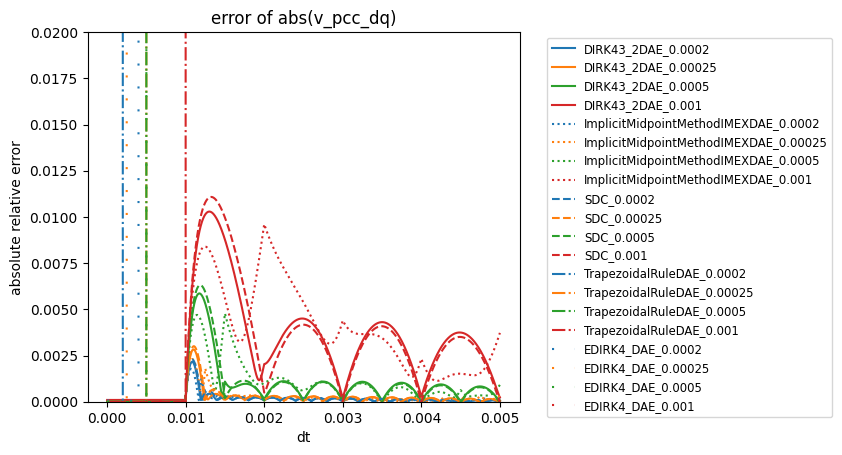

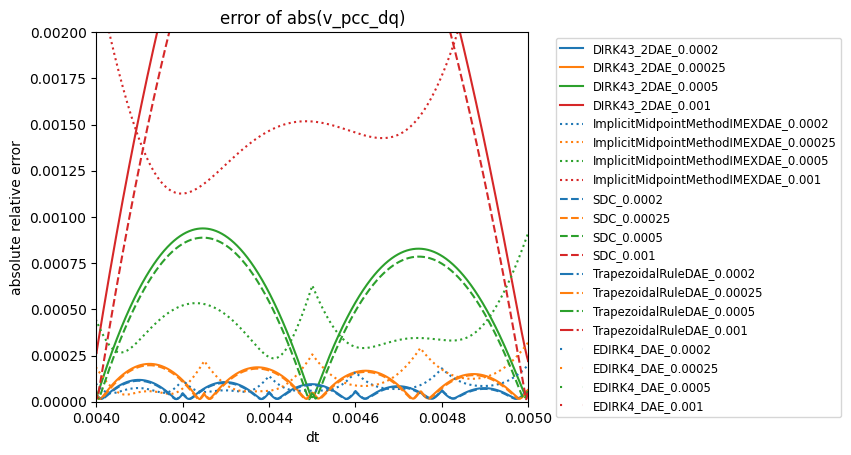

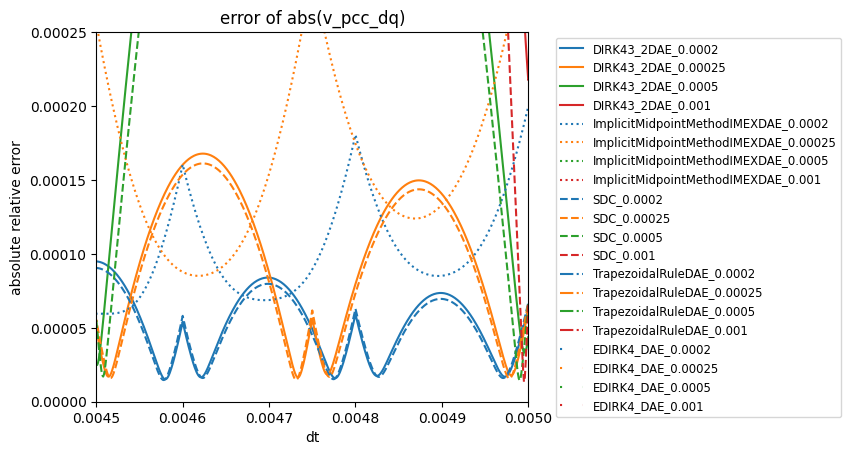

In [31]:
# abs rel error at the last time point

method_list_str = ['DIRK43_2DAE', 'ImplicitMidpointMethodIMEXDAE', 'SDC','TrapezoidalRuleDAE', 'EDIRK4_DAE']
line_styles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1, 10))]
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(1)
for key, val in ar_error_candidates.items():
    for dt_idx in range(len(val)):
        plt.plot(ar_error_candidates[key][dt_idx].time, ar_error_candidates[key][dt_idx].values, linestyle = line_styles[key], color=colors[dt_idx], label=f"{method_list_str[key]}_{dt_list[dt_idx]}")

# Set up legend outside the plot
legend_labels = [f"{method_list_str[key]}_{dt}" for key in ar_error_candidates for dt in dt_list]
plt.legend(labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust the layout to make room for the legend
plt.subplots_adjust(right=0.8)

plt.xlabel("dt")
plt.ylim(0,0.02)
plt.ylabel("absolute relative error")
plt.title("error of abs(v_pcc_dq)")

# plt.figure(2, dpi=300)
# plt.plot(reference_res.time, reference_res.values, label=f"ref")
# for key, val in res_candidates_dq.items():
#     for dt_idx in range(len(val)):
#         # val[res_dt_idx].values = np.vectorize(complex)(val[dt_idx].values[:,0], val[dt_idx].values[:,1])
#         plt.plot(res_candidates_dq[key][dt_idx].time, res_candidates_dq[key][dt_idx].values, linestyle = line_styles[key], color=colors[dt_idx], label=f"{method_list_str[key]}_{dt_list[dt_idx]}")
# plt.legend()
# plt.xlabel("dt")
# plt.ylabel("Magnitude")
# plt.title("abs(v_pcc_dq)")
# plt.show()

plt.figure(2)
for key, val in ar_error_candidates.items():
    for dt_idx in range(len(val)):
        plt.plot(ar_error_candidates[key][dt_idx].time, ar_error_candidates[key][dt_idx].values, linestyle = line_styles[key], color=colors[dt_idx], label=f"{method_list_str[key]}_{dt_list[dt_idx]}")

# Set up legend outside the plot
legend_labels = [f"{method_list_str[key]}_{dt}" for key in ar_error_candidates for dt in dt_list]
plt.legend(labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust the layout to make room for the legend
plt.subplots_adjust(right=0.8)

plt.xlabel("Time (s)")
plt.xlim(0.004,0.005)
plt.ylim(0,0.002)
plt.ylabel("absolute relative error")
plt.title("error of abs(v_pcc_dq)")



plt.figure(3)
for key, val in ar_error_candidates.items():
    for dt_idx in range(len(val)):
        plt.plot(ar_error_candidates[key][dt_idx].time, ar_error_candidates[key][dt_idx].values, linestyle = line_styles[key], color=colors[dt_idx], label=f"{method_list_str[key]}_{dt_list[dt_idx]}")

# Set up legend outside the plot
legend_labels = [f"{method_list_str[key]}_{dt}" for key in ar_error_candidates for dt in dt_list]
plt.legend(labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust the layout to make room for the legend
plt.subplots_adjust(right=0.8)

plt.xlabel("Time (s)")
plt.xlim(0.0045,0.005)
plt.ylim(0,0.00025)
plt.ylabel("absolute relative error")
plt.title("error of abs(v_pcc_dq)")

plt.show()



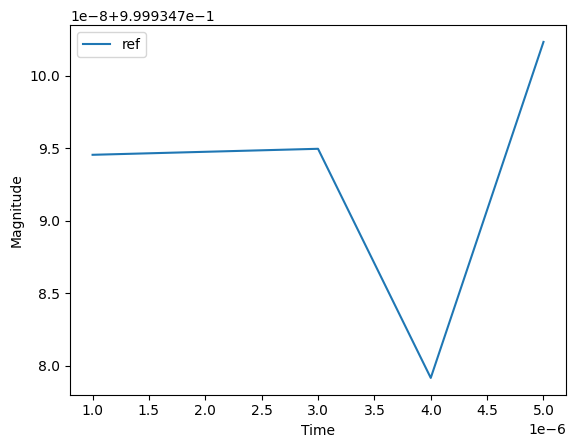

In [27]:
plt.figure(2)
# plt.plot(reference_res.time, reference_res.values, label=f"ref")
plt.plot(reference_res_wscc.time, reference_res_wscc.values, label=f"ref")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
# plt.title("abs(v_pcc_dq)")
# plt.xlim(0,3e-6)
# plt.ylim(0,2)
plt.show()
